*   Nama: Raina Imtiyaz
*   NIM: 2502010976
*   Link Video: https://binusianorg-my.sharepoint.com/personal/raina_imtiyaz_binus_ac_id/_layouts/15/guestaccess.aspx?guestaccesstoken=qBWC2phdFEU492lTu8ayiwXWvvenfeTgQRfDNIewd48%3d&docid=2_031afb15565464714b0e816c11107bf6a&rev=1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
import random
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

### Dataset Cisco Systems, Inc

**a. Data Preprocessing**

In [2]:
df1=pd.read_csv("CSCO.csv")
df1=df1[['Date','Close']]

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7589 entries, 0 to 7588
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7589 non-null   object 
 1   Close   7589 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1 = df1.sort_values('Date', ascending=True)
df1['day'] = df1['Date'].dt.day_name()
df1['next_day'] = df1['Date'].shift(-1).dt.day_name()

Selanjutnya code di atas untuk melakukan beberapa manipulasi pada dataframe df1. Pertama, code tersebut mengubah kolom "Date" menjadi tipe data datetime menggunakan fungsi pd.to_datetime(). Kemudian, dataframe df1 diurutkan berdasarkan nilai kolom "Date" secara menaik (ascending=True) menggunakan fungsi sort_values(). Selanjutnya, code tersebut menambahkan kolom baru bernama "day" yang berisi nama hari dari kolom "Date" menggunakan atribut dt.day_name(). Terakhir, code tersebut menambahkan kolom baru bernama "next_day" yang berisi nama hari dari tanggal selanjutnya dengan menggunakan fungsi shift() dan dt.day_name(). Kolom "next_day" ini berisi nama hari dari tanggal setelahnya dalam urutan yang sama seperti data asli pada kolom "Date".

In [6]:
df1.head(20)

,Date,Close,day,next_day
0,1990-02-16,0.077257,Friday,Tuesday
1,1990-02-20,0.079861,Tuesday,Wednesday
2,1990-02-21,0.078125,Wednesday,Thursday
3,1990-02-22,0.078993,Thursday,Friday
4,1990-02-23,0.078559,Friday,Monday
5,1990-02-26,0.076389,Monday,Tuesday
6,1990-02-27,0.078125,Tuesday,Wednesday
7,1990-02-28,0.080729,Wednesday,Thursday
8,1990-03-01,0.079861,Thursday,Friday
9,1990-03-02,0.080729,Friday,Monday


In [7]:
df1.tail(20)

,Date,Close,day,next_day
7569,2020-03-05,39.570000,Thursday,Friday
7570,2020-03-06,39.680000,Friday,Monday
7571,2020-03-09,37.959999,Monday,Tuesday
7572,2020-03-10,40.080002,Tuesday,Wednesday
7573,2020-03-11,37.049999,Wednesday,Thursday
7574,2020-03-12,33.200001,Thursday,Friday
7575,2020-03-13,37.639999,Friday,Monday
7576,2020-03-16,33.709999,Monday,Tuesday
7577,2020-03-17,35.500000,Tuesday,Wednesday
7578,2020-03-18,37.119999,Wednesday,Thursday


Dari sampel data di atas terlihat bahwa terdapat beberapa data pengamatan yang hilang, misalnya pada data tanggal 1990-02-16 yaitu Friday, tapi hari pada baris selanjutnya adalah Tuesday yang dimana seharusnya Monday dulu.

In [8]:
df1.isnull().sum()

Date        0
Close       0
day         0
next_day    1
dtype: int64

Code di atas menghitung jumlah nilai null (NaN) dalam setiap kolom dataframe df1 menggunakan metode isnull() dan sum(). Hasilnya adalah sebuah series yang menunjukkan jumlah nilai null dalam setiap kolom dataframe. Terlihat bahwa kolom next day terdapat 1 missing value. Hal ini diakibatkan karena tidak ada data berikutnya setelah tanggal 2020-04-01 sehingga menghasilkan next day NaN. Jika dilihat berdsarkan kolom day maka dapat digantikan dengan variabel Thursday.

In [9]:
df1.fillna("Thursday", inplace=True)

Code di atas menggantikan nilai null (NaN) dalam dataframe df1 dengan string "Thursday" menggunakan fungsi fillna(). Dengan parameter inplace=True, penggantian dilakukan secara langsung pada dataframe df1 tanpa perlu menyimpan hasilnya ke dalam variabel baru.

In [10]:
def check_day_order(day, next_day):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    day_index = days.index(day)
    next_day_index = days.index(next_day)
    if day == 'Monday' and next_day == 'Tuesday':
        return 1
    elif day == 'Friday' and next_day == 'Monday':
        return 1
    elif next_day_index == (day_index + 1) % len(days):
        return 1
    else:
        return 0

* Code di atas mendefinisikan sebuah fungsi bernama check_day_order() dengan dua parameter, yaitu "day" dan "next_day". Fungsi ini digunakan untuk memeriksa urutan hari antara "day" dan "next_day" yang diberikan.

* Pada awal fungsi, terdapat inisialisasi variabel "days" yang berisi daftar hari dalam urutan: 'Monday', 'Tuesday', 'Wednesday', 'Thursday', dan 'Friday'. Kemudian, fungsi ini mengambil indeks hari "day" dan "next_day" dalam daftar "days" menggunakan metode index() dan menyimpannya dalam variabel "day_index" dan "next_day_index" secara berturut-turut.

* Fungsi kemudian melakukan beberapa kondisi untuk memeriksa urutan hari antara "day" dan "next_day". Pertama, jika "day" adalah 'Monday' dan "next_day" adalah 'Tuesday', fungsi akan mengembalikan nilai 1. Selanjutnya, jika "day" adalah 'Friday' dan "next_day" adalah 'Monday', fungsi juga akan mengembalikan nilai 1. Hal ini mengindikasikan bahwa urutan hari dari 'Friday' ke 'Monday' atau dari 'Monday' ke 'Tuesday' dianggap benar.

* Selain itu, fungsi juga memeriksa apakah indeks "next_day" adalah hasil dari penambahan 1 terhadap "day_index" (dengan menggunakan operasi modulus len(days)). Jika kondisi ini terpenuhi, fungsi akan mengembalikan nilai 1, yang menunjukkan urutan hari yang benar.

* Jika tidak ada kondisi yang terpenuhi, fungsi akan mengembalikan nilai 0, yang menandakan bahwa urutan hari antara "day" dan "next_day" tidak sesuai.

* Dengan menggunakan fungsi ini, kita dapat memeriksa apakah urutan hari dalam dataframe df1 adalah urutan hari yang benar atau tidak.

In [11]:
# Terapkan fungsi check_day_order ke DataFrame
df1['ordered'] = df1.apply(lambda row: check_day_order(row['day'], row['next_day']), axis=1)

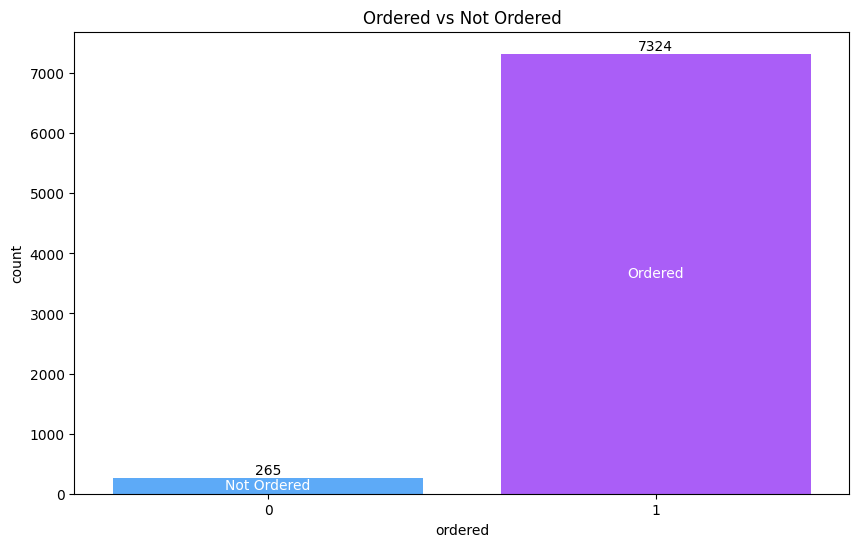

In [13]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data = df1, x ='ordered', palette='cool',
                    saturation=0.9)
for container in ax.containers:
    ax.bar_label(container)
ax.bar_label(container=ax.containers[0], labels=['Not Ordered', 'Ordered'],
              label_type='center', size=10, color='w')
plt.title("Ordered vs Not Ordered")
plt.show()

Dari output di atas dapat dilihat bahwa terdapat 265 pengamatan yang tidak berurutan dengan data pengamatan berikutnya. Oleh karena itu akan dilakukan interpolasi sehingga data time series yang diperoleh lengkap secara daily. Adapun untuk kolom Close akan diduga berdasarkan nilai Close sebelum dan sesudah pengamatan yang akan dilengkapi.

In [14]:
df1=df1.drop("next_day", axis=1)

# Mengubah index dataframe menjadi kolom "Date"
df1 = df1.set_index('Date')

# Membuat range tanggal mulai dari tanggal pertama hingga tanggal terakhir
date_range = pd.date_range(start=df1.index.min(), end=df1.index.max(), freq='D')

# Membuat dataframe baru dengan index berdasarkan range tanggal
df2 = pd.DataFrame(index=date_range)

# Menggabungkan dataframe df1 dengan df2 untuk melengkapi tanggal
df_complete = df2.merge(df1, how='left', left_index=True, right_index=True)

# Mengisi nilai kosong pada kolom "Close" dengan rata-rata nilai sebelum dan sesudahnya
df_complete['Close'] = df_complete['Close'].fillna((df_complete['Close'].shift() + df_complete['Close'].shift(-1)) / 2)

# Mengatur ulang index menjadi kolom "Date"
df_complete = df_complete.reset_index()

df_complete=df_complete.rename(columns={"index": "Date"})

# Mengurutkan dataframe berdasarkan kolom "Date"
df_complete = df_complete.sort_values('Date')

# Mengubah tipe data kolom "Date" menjadi string
df_complete['Date'] = df_complete['Date'].dt.strftime('%Y-%m-%d')

* Code di atas melakukan beberapa operasi pada dataframe df1 untuk melengkapi tanggal yang hilang dan melakukan beberapa perubahan pada data.

* Pertama, code tersebut menggunakan fungsi drop() untuk menghapus kolom "next_day" dari dataframe df1. Dalam hal ini, axis=1 digunakan untuk mengindikasikan bahwa yang dihapus adalah sebuah kolom.

* Selanjutnya, code tersebut menggunakan set_index() untuk mengubah indeks dataframe df1 menjadi kolom "Date". Dengan demikian, kolom "Date" tidak lagi berfungsi sebagai indeks.

* Kemudian, code tersebut menggunakan fungsi date_range() untuk membuat rentang tanggal mulai dari tanggal pertama hingga tanggal terakhir yang ada dalam dataframe df1. Frekuensi yang digunakan adalah 'D', yang berarti harian.

* Selanjutnya, code tersebut membuat dataframe baru dengan menggunakan pd.DataFrame() dan mengatur indexnya berdasarkan range tanggal yang telah dibuat sebelumnya. Dataframe baru ini disimpan dalam variabel df2.

* Selanjutnya, code tersebut menggunakan merge() untuk menggabungkan dataframe df1 dengan df2 menggunakan kolom-kolom yang sesuai. Tujuannya adalah untuk melengkapi tanggal yang mungkin hilang pada dataframe df1. Penggabungan dilakukan dengan menggunakan left join (how='left') berdasarkan index pada kedua dataframe.

* Setelah itu, code tersebut mengisi nilai kosong (NaN) pada kolom "Close" dengan menggunakan rata-rata dari nilai sebelum dan sesudahnya. Hal ini dilakukan dengan menggunakan fungsi fillna() dan shift() untuk mendapatkan nilai sebelum dan sesudahnya.

* Selanjutnya, code tersebut menggunakan reset_index() untuk mengatur ulang indeks dataframe menjadi kolom "Date".

* Selanjutnya, code tersebut menggunakan rename() untuk mengganti nama kolom "index" menjadi "Date" pada dataframe df_complete.

* Kemudian, code tersebut menggunakan sort_values() untuk mengurutkan dataframe df_complete berdasarkan kolom "Date".

* Terakhir, code tersebut menggunakan strftime() untuk mengubah tipe data kolom "Date" menjadi string dengan format tahun-bulan-tanggal ('%Y-%m-%d').

In [15]:
df_complete

,Date,Close,day,ordered
0,1990-02-16,0.077257,Friday,0.0
1,1990-02-17,NaN,NaN,NaN
2,1990-02-18,NaN,NaN,NaN
3,1990-02-19,NaN,NaN,NaN
4,1990-02-20,0.079861,Tuesday,1.0
...,...,...,...,...
10998,2020-03-28,NaN,NaN,NaN
10999,2020-03-29,NaN,NaN,NaN
11000,2020-03-30,40.320000,Monday,1.0
11001,2020-03-31,39.310001,Tuesday,1.0


In [16]:
# Mengisi nilai kosong pada kolom "Close" dengan rata-rata nilai terdekat
df_complete['Close'] = df_complete['Close'].fillna(df_complete['Close'].interpolate())

* Code di atas mengisi nilai kosong (NaN) pada kolom "Close" dalam dataframe df_complete dengan menggunakan metode interpolasi.

* Dalam code tersebut, df_complete['Close'].interpolate() digunakan untuk menghasilkan serangkaian nilai yang dihasilkan dari interpolasi linier terhadap nilai yang tersedia di kolom "Close". Interpolasi linier ini mengisi nilai yang hilang dengan nilai rata-rata dari nilai sebelum dan sesudahnya.

* Selanjutnya, hasil dari interpolasi linier ini diassign kembali ke kolom "Close" dalam dataframe df_complete menggunakan df_complete['Close'] = df_complete['Close'].fillna(...).

* Dengan demikian, nilai kosong dalam kolom "Close" akan diisi dengan rata-rata dari nilai sebelum dan sesudahnya menggunakan metode interpolasi linier.

In [17]:
df_complete['Date'] = pd.to_datetime(df_complete['Date'])
df_complete['day'] = df_complete['Date'].dt.day_name()

In [18]:
df_final1=df_complete[~df_complete.day.isin(['Saturday',"Sunday"])]

* Setelah data dilengkapi secara daily maka Code berikut untuk menghilangkan data yang merupakan Saturday dan Sunday.

* Dalam code tersebut, ~ digunakan sebagai operator negasi untuk mengambil data yang tidak memenuhi kondisi yang diberikan. Dalam hal ini, kita ingin mengambil data di mana kolom "day" bukan merupakan hari Sabtu ('Saturday') atau Minggu ('Sunday').

* Jadi, df_final akan berisi data dari df_complete yang tidak jatuh pada hari Sabtu atau Minggu.

In [19]:
df_final1['next_day'] = df_final1['Date'].shift(-1).dt.day_name()
df_final1=df_final1.drop(['ordered'], axis=1).reset_index(drop=True)

<ipython-input-19-f7b6c3c3a623>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final1['next_day'] = df_final1['Date'].shift(-1).dt.day_name()


In [20]:
df_final1

,Date,Close,day,next_day
0,1990-02-16,0.077257,Friday,Monday
1,1990-02-19,0.079210,Monday,Tuesday
2,1990-02-20,0.079861,Tuesday,Wednesday
3,1990-02-21,0.078125,Wednesday,Thursday
4,1990-02-22,0.078993,Thursday,Friday
...,...,...,...,...
7854,2020-03-26,40.580002,Thursday,Friday
7855,2020-03-27,38.820000,Friday,Monday
7856,2020-03-30,40.320000,Monday,Tuesday
7857,2020-03-31,39.310001,Tuesday,Wednesday


In [21]:
df_final1.fillna("Thursday", inplace=True)
df_final1['ordered'] = df_final1.apply(lambda row: check_day_order(row['day'], row['next_day']), axis=1)

In [22]:
df_final1.ordered.value_counts()

1    7859
Name: ordered, dtype: int64

Dari output di atas terlihat bahwa semua data sudah berurutan.

In [23]:
df_final1

,Date,Close,day,next_day,ordered
0,1990-02-16,0.077257,Friday,Monday,1
1,1990-02-19,0.079210,Monday,Tuesday,1
2,1990-02-20,0.079861,Tuesday,Wednesday,1
3,1990-02-21,0.078125,Wednesday,Thursday,1
4,1990-02-22,0.078993,Thursday,Friday,1
...,...,...,...,...,...
7854,2020-03-26,40.580002,Thursday,Friday,1
7855,2020-03-27,38.820000,Friday,Monday,1
7856,2020-03-30,40.320000,Monday,Tuesday,1
7857,2020-03-31,39.310001,Tuesday,Wednesday,1


In [24]:
# Memisahkan data menjadi input dan output
window_size = 5
horizon = 5
# Mengambil kolom Close dan day
df_input = df_final1[['Close', 'day']].copy()

# Membuat kolom output dengan horizon
horizon = 5
df_input['Output'] = df_input['Close'].shift(-horizon)

# Menghapus baris yang memiliki nilai NaN pada Output
df_input = df_input.dropna()

# Membuat windowed dataset
window_size = 5

input_data = []
output_data = []

for i in range(len(df_input) - window_size + 1):
    input_window = df_input.iloc[i:i+window_size][['Close']].values
    output_window = df_input.iloc[i+window_size-1]['Output']
    input_data.append(input_window)
    output_data.append(output_window)

input_data = np.array(input_data)
output_data = np.array(output_data)

# Memisahkan dataset menjadi training, testing, dan validation set
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=1 - train_ratio, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + val_ratio), shuffle=False)


* Code di atas melakukan pemisahan data menjadi input dan output serta memisahkan dataset menjadi training, testing, dan validation set.

* Pertama, code tersebut menentukan window size (ukuran jendela) dan horizon (horizon) yang akan digunakan dalam memisahkan data menjadi input dan output.

* Selanjutnya, kolom "Close" dan "day" diambil dari dataframe df_final1 menggunakan df_final1[['Close', 'day']].copy() dan disimpan dalam df_input.

* Kemudian, kolom "Output" dibuat dengan menggunakan horizon sebagai jarak pergeseran (shift) dari kolom "Close". Hal ini dilakukan dengan df_input['Output'] = df_input['Close'].shift(-horizon). Kolom "Output" berisi nilai Close di masa depan sesuai dengan horizon yang ditentukan.

* Selanjutnya, baris yang memiliki nilai NaN pada kolom "Output" dihapus menggunakan df_input = df_input.dropna().

* Setelah itu, dilakukan pembentukan windowed dataset. Perulangan for digunakan untuk membagi data input dan output menjadi jendela waktu berukuran window_size. Pada setiap iterasi, nilai Close dalam jendela waktu diambil sebagai input_window, dan nilai Output pada baris terakhir jendela diambil sebagai output_window. Data input dan output tersebut ditambahkan ke dalam input_data dan output_data secara berturut-turut.

* Selanjutnya, input_data dan output_data diubah menjadi array numpy menggunakan np.array().

* Kemudian, dataset dibagi menjadi training, testing, dan validation set menggunakan train_test_split(). Dalam hal ini, test_size dan val_size ditentukan berdasarkan rasio yang telah ditentukan (train_ratio, val_ratio, test_ratio). Dataset dibagi secara berurutan (shuffle=False) agar urutan waktu tetap terjaga.

* Dengan langkah-langkah ini, data telah dipersiapkan dalam bentuk input dan output serta telah dipisahkan menjadi training, testing, dan validation set.

b. Buat baseline architecture sesuai dengan arsitektur transformer

In [25]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(d_ff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.multi_head_attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_model(d_model, num_heads, d_ff, input_shape, output_shape, horizon):
    inputs = Input(shape=input_shape)
    x = inputs
    x = tf.keras.layers.Embedding(d_model, input_shape[-1])(x)
    x = Dropout(0.1)(x)

    # Positional Encoding
    pos_encoding = np.zeros((1, input_shape[1], d_model))
    for pos in range(input_shape[1]):
        for i in range(0, d_model, 2):
            pos_encoding[:, pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
            pos_encoding[:, pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
    x += pos_encoding

    # Transformer Encoder layers
    for _ in range(num_layers):
        x = TransformerEncoderLayer(d_model, num_heads, d_ff)(x)

    # Conv1D
    x = Conv1D(64, 3, activation='relu', padding='same')(x)

    # GlobalAveragePooling1D
    x = tf.reduce_mean(x, axis=1)

    # Output layer
    outputs = Dense(output_shape)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Hyperparameters
d_model = 128
num_heads = 4
d_ff = 512
num_layers = 2
input_shape = (5, 1)
output_shape = 1

# Create the Transformer model
model_baseline = create_transformer_model(d_model, num_heads, d_ff, input_shape, output_shape, 1)

# Compile the model
model_baseline.compile(optimizer=Adam(learning_rate=0.1), loss='mse', metrics=['mae'])

# Train the model
model_baseline.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)



Epoch 1/10
197/197 [==============================] - 8s 27ms/step - loss: 206.8127 - mae: 10.5881 - val_loss: 175.0699 - val_mae: 12.9607
Epoch 2/10
197/197 [==============================] - 6s 28ms/step - loss: 190.3378 - mae: 10.1133 - val_loss: 74.3824 - val_mae: 8.2032
Epoch 3/10
197/197 [==============================] - 5s 25ms/step - loss: 194.0538 - mae: 10.2137 - val_loss: 191.2184 - val_mae: 13.5694
Epoch 4/10
197/197 [==============================] - 6s 28ms/step - loss: 185.2377 - mae: 9.8774 - val_loss: 149.4986 - val_mae: 11.9334
Epoch 5/10
197/197 [==============================] - 5s 25ms/step - loss: 213.8621 - mae: 10.4277 - val_loss: 401.2574 - val_mae: 19.8537
Epoch 6/10
197/197 [==============================] - 5s 26ms/step - loss: 191.0333 - mae: 10.1262 - val_loss: 133.8381 - val_mae: 11.2583
Epoch 7/10
197/197 [==============================] - 5s 28ms/step - loss: 181.1485 - mae: 9.7099 - val_loss: 133.8686 - val_mae: 11.2596
Epoch 8/10
197/197 [===========

* Code di atas mendefinisikan kelas TransformerEncoderLayer yang merupakan lapisan transformer encoder dalam model transformer. Kelas ini memiliki fungsi init() yang menginisialisasi lapisan-lapisan yang digunakan dalam transformer encoder, seperti multi-head attention, feed-forward network, layer normalization, dan dropout. Kelas ini juga memiliki fungsi call() yang melakukan proses pemanggilan lapisan-lapisan tersebut secara berurutan.

* Selanjutnya, terdapat fungsi create_transformer_model() yang digunakan untuk membuat model transformer. Fungsi ini menerima beberapa parameter seperti dimensi model (d_model), jumlah kepala (num_heads), dimensi feed-forward network (d_ff), bentuk input dan output, serta horizon (horizon) yang merupakan jumlah langkah waktu yang diprediksi. Fungsi ini mengatur arsitektur model transformer dengan menggunakan lapisan TransformerEncoderLayer, Conv1D, dan Dense. Fungsi ini juga mengatur positional encoding pada input dan melakukan pengurangan rata-rata global pada output sebelum dilanjutkan ke lapisan Dense output.

* Setelah itu, code tersebut mendefinisikan hyperparameters seperti d_model, num_heads, d_ff, num_layers, input_shape, dan output_shape.

* Selanjutnya, model_baseline dibuat dengan memanggil fungsi create_transformer_model() dengan menggunakan hyperparameters dan input_shape dan output_shape yang telah ditentukan.

* Model ini kemudian dikompilasi menggunakan optimizer Adam dengan learning rate 0.1, loss function 'mse' (mean squared error), dan metrics 'mae' (mean absolute error).

* Selanjutnya, model_baseline dilatih menggunakan data pelatihan (X_train dan y_train) dengan menggunakan metode fit(). Data validasi (X_val dan y_val) juga digunakan untuk melakukan evaluasi model setiap epoch. Jumlah epoch dan batch size juga ditentukan dalam metode fit().

* Dengan langkah-langkah ini, model transformer dengan lapisan TransformerEncoderLayer telah dibangun dan dilatih menggunakan data input dan output yang telah dipersiapkan sebelumnya.

**c. Modifikasi Arsitektur**


In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

class ModifiedTransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, rate=0.1):
        super(ModifiedTransformerEncoderLayer, self).__init__()
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(d_ff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.multi_head_attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_model(d_model, num_heads, d_ff, input_shape, output_shape, horizon):
    inputs = Input(shape=input_shape)
    x = inputs
    x = tf.keras.layers.Embedding(d_model, input_shape[-1])(x)
    x = Dropout(0.2)(x)

    # Positional Encoding
    pos_encoding = np.zeros((1, input_shape[1], d_model))
    for pos in range(input_shape[1]):
        for i in range(0, d_model, 2):
            pos_encoding[:, pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
            pos_encoding[:, pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
    x += pos_encoding

    # Modified Transformer Encoder layers
    for _ in range(num_layers):
        x = ModifiedTransformerEncoderLayer(d_model, num_heads, d_ff)(x)
        x = Dropout(0.2)(x)

    # Conv1D
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)

    # GlobalAveragePooling1D
    x = tf.reduce_mean(x, axis=1)

    # Output layer
    outputs = Dense(output_shape)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Hyperparameters
d_model = 128
num_heads = 4
d_ff = 512
num_layers = 2
input_shape = (5, 1)
output_shape = 1

# Create the Transformer model
model_modified = create_transformer_model(d_model, num_heads, d_ff, input_shape, output_shape, 1)

# Compile the model
model_modified.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Train the model
model_modified.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
197/197 [==============================] - 10s 33ms/step - loss: 188.7155 - mae: 10.0274 - val_loss: 121.2796 - val_mae: 10.6860
Epoch 2/10
197/197 [==============================] - 6s 28ms/step - loss: 184.7851 - mae: 9.9430 - val_loss: 102.8233 - val_mae: 9.7844
Epoch 3/10
197/197 [==============================] - 6s 31ms/step - loss: 184.0641 - mae: 9.8275 - val_loss: 162.8823 - val_mae: 12.4817
Epoch 4/10
197/197 [==============================] - 6s 28ms/step - loss: 184.7738 - mae: 9.8610 - val_loss: 115.7634 - val_mae: 10.4247
Epoch 5/10
197/197 [==============================] - 6s 31ms/step - loss: 184.2117 - mae: 9.8707 - val_loss: 163.5350 - val_mae: 12.5078
Epoch 6/10
197/197 [==============================] - 6s 28ms/step - loss: 185.4668 - mae: 9.9304 - val_loss: 114.8408 - val_mae: 10.3804
Epoch 7/10
197/197 [==============================] - 6s 30ms/step - loss: 184.5173 - mae: 9.8729 - val_loss: 89.3741 - val_mae: 9.0711
Epoch 8/10
197/197 [===============

* Code di atas mengimplementasikan kelas ModifiedTransformerEncoderLayer yang merupakan variasi dari kelas TransformerEncoderLayer sebelumnya. Kelas ini memiliki fungsi init() dan call() yang serupa dengan kelas sebelumnya.

* Selanjutnya, terdapat fungsi create_transformer_model() yang digunakan untuk membuat model transformer yang dimodifikasi. Fungsi ini hampir serupa dengan fungsi sebelumnya, namun ditambahkan Dropout(0.2) setelah setiap lapisan ModifiedTransformerEncoderLayer untuk mengurangi overfitting.

* Setelah itu, code tersebut mendefinisikan hyperparameters seperti d_model, num_heads, d_ff, num_layers, input_shape, dan output_shape.

* Selanjutnya, model_modified dibuat dengan memanggil fungsi create_transformer_model() dengan menggunakan hyperparameters dan input_shape dan output_shape yang telah ditentukan.

* Model ini kemudian dikompilasi menggunakan optimizer Adam dengan learning rate 0.001, loss function 'mse' (mean squared error), dan metrics 'mae' (mean absolute error).

* Selanjutnya, model_modified dilatih menggunakan data pelatihan (X_train dan y_train) dengan menggunakan metode fit(). Data validasi (X_val dan y_val) juga digunakan untuk melakukan evaluasi model setiap epoch. Jumlah epoch dan batch size juga ditentukan dalam metode fit().

* Dengan langkah-langkah ini, model transformer dengan lapisan ModifiedTransformerEncoderLayer telah dibangun dan dilatih menggunakan data input dan output yang telah dipersiapkan sebelumnya.

** d. Evaluasi**

In [28]:
# Evaluate the model Baseline
loss, mae = model_baseline.evaluate(X_test, y_test)
print("Test RMSE Model Baseline:", loss)
print("Test MAE Model Baseline:", mae)

# Evaluate the model modified
loss, mae = model_modified.evaluate(X_test, y_test)
print("Test RMSE Model modified:", loss)
print("Test MAE Model modified:", mae)


25/25 [==============================] - 0s 8ms/step - loss: 773.8400 - mae: 26.8359
Test RMSE Model Baseline: 773.8400268554688
Test MAE Model Baseline: 26.835866928100586
25/25 [==============================] - 0s 8ms/step - loss: 709.4243 - mae: 25.6076
Test RMSE Model modified: 709.4242553710938
Test MAE Model modified: 25.60757827758789


* Code di atas melakukan evaluasi terhadap model baseline dan model yang dimodifikasi menggunakan data pengujian (X_test dan y_test).

* Pada model_baseline, code tersebut menggunakan model_baseline.evaluate(X_test, y_test) untuk menghitung loss dan metrik MAE pada data pengujian. Hasil loss disimpan dalam variabel loss, dan hasil MAE disimpan dalam variabel mae.

* Selanjutnya, code tersebut mencetak hasil evaluasi dengan mencetak nilai loss dan mae menggunakan print(). Hasil evaluasi tersebut memberikan informasi tentang seberapa baik model baseline bekerja pada data pengujian.

* Pada model_modified, code tersebut menggunakan model_modified.evaluate(X_test, y_test) untuk menghitung loss dan metrik MAE pada data pengujian. Hasil loss disimpan dalam variabel loss, dan hasil MAE disimpan dalam variabel mae.

* Selanjutnya, code tersebut mencetak hasil evaluasi dengan mencetak nilai loss dan mae menggunakan print(). Hasil evaluasi tersebut memberikan informasi tentang seberapa baik model yang dimodifikasi bekerja pada data pengujian.

* Dengan langkah-langkah ini, model baseline dan model yang dimodifikasi dievaluasi menggunakan data pengujian, dan hasil evaluasi dicetak untuk memperoleh informasi tentang performa kedua model.

Berdasarkan hasil yang diberikan, dapat disimpulkan bahwa terdapat dua model yang dievaluasi. Model pertama disebut sebagai "Model Baseline" dan model kedua disebut sebagai "Model Modified".

Untuk Model Baseline:

* Loss yang dihasilkan adalah sebesar 773.8400.
* MAE (Mean Absolute Error) yang dihasilkan adalah sebesar 26.8359.
* RMSE (Root Mean Square Error) pada pengujian model adalah sebesar 773.8400.
* MAE pada pengujian model adalah sebesar 26.8359.

Sementara itu, untuk Model Modified:

* Loss yang dihasilkan adalah sebesar 709.4243.
* MAE yang dihasilkan adalah sebesar 25.6076.
* RMSE pada pengujian model adalah sebesar 709.4242.
* MAE pada pengujian model adalah sebesar 25.6076.

Berdasarkan perbandingan hasil di atas, dapat disimpulkan bahwa Model Modified menghasilkan performa yang lebih baik daripada Model Baseline. Hal ini ditunjukkan dengan nilai loss yang lebih rendah (709.4243 vs 773.8400) dan MAE yang lebih kecil (25.6076 vs 26.8359). Oleh karena itu, Model Modified merupakan versi yang lebih baik dan lebih akurat dalam melakukan prediksi atau tugas yang terkait dengan model tersebut.

 ### Dataset Amazon.com, Inc

**a. Data Preprocessing**

In [ ]:
df2=pd.read_csv("AMZN.csv")
df2=df2[['Date','Close']]

In [ ]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5758 non-null   object 
 1   Close   5758 non-null   float64
dtypes: float64(1), object(1)
memory usage: 90.1+ KB
None


In [ ]:
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values('Date', ascending=True)
df2['day'] = df2['Date'].dt.day_name()
df2['next_day'] = df2['Date'].shift(-1).dt.day_name()

In [ ]:
df2.head(10)

,Date,Close,day,next_day
0,1997-05-15,1.958333,Thursday,Friday
1,1997-05-16,1.729167,Friday,Monday
2,1997-05-19,1.708333,Monday,Tuesday
3,1997-05-20,1.635417,Tuesday,Wednesday
4,1997-05-21,1.427083,Wednesday,Thursday
5,1997-05-22,1.395833,Thursday,Friday
6,1997-05-23,1.500000,Friday,Tuesday
7,1997-05-27,1.583333,Tuesday,Wednesday
8,1997-05-28,1.531250,Wednesday,Thursday
9,1997-05-29,1.505208,Thursday,Friday


In [ ]:
df2.tail(10)

,Date,Close,day,next_day
5748,2020-03-19,1880.930054,Thursday,Friday
5749,2020-03-20,1846.089966,Friday,Monday
5750,2020-03-23,1902.829956,Monday,Tuesday
5751,2020-03-24,1940.099976,Tuesday,Wednesday
5752,2020-03-25,1885.839966,Wednesday,Thursday
5753,2020-03-26,1955.489990,Thursday,Friday
5754,2020-03-27,1900.099976,Friday,Monday
5755,2020-03-30,1963.949951,Monday,Tuesday
5756,2020-03-31,1949.719971,Tuesday,Wednesday
5757,2020-04-01,1907.699951,Wednesday,NaN


In [ ]:
df2.isnull().sum()

Date        0
Close       0
day         0
next_day    1
dtype: int64

In [ ]:
df2.fillna("Thursday", inplace=True)

In [ ]:
def check_day_order(day, next_day):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    day_index = days.index(day)
    next_day_index = days.index(next_day)
    if day == 'Monday' and next_day == 'Tuesday':
        return 1
    elif day == 'Friday' and next_day == 'Monday':
        return 1
    elif next_day_index == (day_index + 1) % len(days):
        return 1
    else:
        return 0

* Code di atas mendefinisikan sebuah fungsi bernama check_day_order() dengan dua parameter, yaitu "day" dan "next_day". Fungsi ini digunakan untuk memeriksa urutan hari antara "day" dan "next_day" yang diberikan.

* Pada awal fungsi, terdapat inisialisasi variabel "days" yang berisi daftar hari dalam urutan: 'Monday', 'Tuesday', 'Wednesday', 'Thursday', dan 'Friday'. Kemudian, fungsi ini mengambil indeks hari "day" dan "next_day" dalam daftar "days" menggunakan metode index() dan menyimpannya dalam variabel "day_index" dan "next_day_index" secara berturut-turut.

* Fungsi kemudian melakukan beberapa kondisi untuk memeriksa urutan hari antara "day" dan "next_day". Pertama, jika "day" adalah 'Monday' dan "next_day" adalah 'Tuesday', fungsi akan mengembalikan nilai 1. Selanjutnya, jika "day" adalah 'Friday' dan "next_day" adalah 'Monday', fungsi juga akan mengembalikan nilai 1. Hal ini mengindikasikan bahwa urutan hari dari 'Friday' ke 'Monday' atau dari 'Monday' ke 'Tuesday' dianggap benar.

* Selain itu, fungsi juga memeriksa apakah indeks "next_day" adalah hasil dari penambahan 1 terhadap "day_index" (dengan menggunakan operasi modulus len(days)). Jika kondisi ini terpenuhi, fungsi akan mengembalikan nilai 1, yang menunjukkan urutan hari yang benar.

* Jika tidak ada kondisi yang terpenuhi, fungsi akan mengembalikan nilai 0, yang menandakan bahwa urutan hari antara "day" dan "next_day" tidak sesuai.

* Dengan menggunakan fungsi ini, kita dapat memeriksa apakah urutan hari dalam dataframe df1 adalah urutan hari yang benar atau tidak.

In [ ]:
# Terapkan fungsi check_day_order ke DataFrame
df2['ordered'] = df2.apply(lambda row: check_day_order(row['day'], row['next_day']), axis=1)

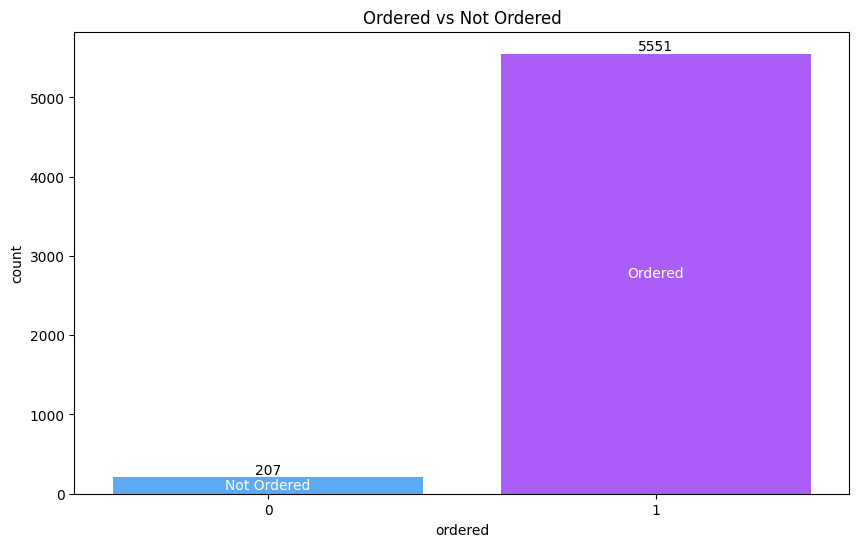

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data = df2, x ='ordered', palette='cool',
                    saturation=0.9)
for container in ax.containers:
    ax.bar_label(container)
ax.bar_label(container=ax.containers[0], labels=['Not Ordered', 'Ordered'],
              label_type='center', size=10, color='w')
plt.title("Ordered vs Not Ordered")
plt.show()

In [ ]:
df2=df2.drop("next_day", axis=1)

# Mengubah index dataframe menjadi kolom "Date"
df2 = df2.set_index('Date')

# Membuat range tanggal mulai dari tanggal pertama hingga tanggal terakhir
date_range = pd.date_range(start=df2.index.min(), end=df2.index.max(), freq='D')

# Membuat dataframe baru dengan index berdasarkan range tanggal
df3 = pd.DataFrame(index=date_range)

# Menggabungkan dataframe df3 dengan df2 untuk melengkapi tanggal
df_complete = df3.merge(df2, how='left', left_index=True, right_index=True)

# Mengisi nilai kosong pada kolom "Close" dengan rata-rata nilai sebelum dan sesudahnya
df_complete['Close'] = df_complete['Close'].fillna((df_complete['Close'].shift() + df_complete['Close'].shift(-1)) / 2)

# Mengatur ulang index menjadi kolom "Date"
df_complete = df_complete.reset_index()

df_complete=df_complete.rename(columns={"index": "Date"})

# Mengurutkan dataframe berdasarkan kolom "Date"
df_complete = df_complete.sort_values('Date')

# Mengubah tipe data kolom "Date" menjadi string
df_complete['Date'] = df_complete['Date'].dt.strftime('%Y-%m-%d')

In [ ]:
df_complete['Close'] = df_complete['Close'].fillna((df_complete['Close'].shift() + df_complete['Close'].shift(-1)) / 2)


In [ ]:
# Mengisi nilai kosong pada kolom "Close" dengan rata-rata nilai terdekat
df_complete['Close'] = df_complete['Close'].fillna(df_complete['Close'].interpolate())

In [ ]:
df_complete['Date'] = pd.to_datetime(df_complete['Date'])
df_complete['day'] = df_complete['Date'].dt.day_name()

In [ ]:
df_final2=df_complete[~df_complete.day.isin(['Saturday',"Sunday"])]

In [ ]:
df_final2['next_day'] = df_final2['Date'].shift(-1).dt.day_name()
df_final2=df_final2.drop(['ordered'], axis=1).reset_index(drop=True)

<ipython-input-43-7fe6fcf968a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final2['next_day'] = df_final2['Date'].shift(-1).dt.day_name()


In [ ]:
df_final2.fillna("Thursday", inplace=True)
df_final2['ordered'] = df_final2.apply(lambda row: check_day_order(row['day'], row['next_day']), axis=1)

In [ ]:
df_final2.ordered.value_counts()

1    5970
Name: ordered, dtype: int64

In [ ]:
df_final2

,Date,Close,day,next_day,ordered
0,1997-05-15,1.958333,Thursday,Friday,1
1,1997-05-16,1.729167,Friday,Monday,1
2,1997-05-19,1.708333,Monday,Tuesday,1
3,1997-05-20,1.635417,Tuesday,Wednesday,1
4,1997-05-21,1.427083,Wednesday,Thursday,1
...,...,...,...,...,...
5965,2020-03-26,1955.489990,Thursday,Friday,1
5966,2020-03-27,1900.099976,Friday,Monday,1
5967,2020-03-30,1963.949951,Monday,Tuesday,1
5968,2020-03-31,1949.719971,Tuesday,Wednesday,1


In [ ]:
# Memisahkan data menjadi input dan output
window_size = 5
horizon = 5
# Mengambil kolom Close dan day
df_input = df_final2[['Close', 'day']].copy()

# Membuat kolom output dengan horizon
horizon = 5
df_input['Output'] = df_input['Close'].shift(-horizon)

# Menghapus baris yang memiliki nilai NaN pada Output
df_input = df_input.dropna()

# Membuat windowed dataset
window_size = 5

input_data = []
output_data = []

for i in range(len(df_input) - window_size + 1):
    input_window = df_input.iloc[i:i+window_size][['Close']].values
    output_window = df_input.iloc[i+window_size-1]['Output']
    input_data.append(input_window)
    output_data.append(output_window)

input_data = np.array(input_data)
output_data = np.array(output_data)

# Memisahkan dataset menjadi training, testing, dan validation set
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=1 - train_ratio, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + val_ratio), shuffle=False)


**b. Buat baseline architecture sesuai dengan arsitektur transformer**

In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(d_ff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.multi_head_attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_model(d_model, num_heads, d_ff, input_shape, output_shape, horizon):
    inputs = Input(shape=input_shape)
    x = inputs
    x = tf.keras.layers.Embedding(d_model, input_shape[-1])(x)
    x = Dropout(0.1)(x)

    # Positional Encoding
    pos_encoding = np.zeros((1, input_shape[1], d_model))
    for pos in range(input_shape[1]):
        for i in range(0, d_model, 2):
            pos_encoding[:, pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
            pos_encoding[:, pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
    x += pos_encoding

    # Transformer Encoder layers
    for _ in range(num_layers):
        x = TransformerEncoderLayer(d_model, num_heads, d_ff)(x)

    # Conv1D
    x = Conv1D(64, 3, activation='relu', padding='same')(x)

    # GlobalAveragePooling1D
    x = tf.reduce_mean(x, axis=1)

    # Output layer
    outputs = Dense(output_shape)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Hyperparameters
d_model = 128
num_heads = 4
d_ff = 512
num_layers = 2
input_shape = (5, 1)
output_shape = 1

# Create the Transformer model
model_baseline = create_transformer_model(d_model, num_heads, d_ff, input_shape, output_shape, 1)

# Compile the model
model_baseline.compile(optimizer=Adam(learning_rate=0.1), loss='mse', metrics=['mae'])

# Train the model
model_baseline.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)



Epoch 1/10
149/149 [==============================] - 21s 86ms/step - loss: 13842.1699 - mae: 92.3161 - val_loss: 546647.8125 - val_mae: 719.4159
Epoch 2/10
149/149 [==============================] - 3s 20ms/step - loss: 13686.5498 - mae: 92.0692 - val_loss: 475794.0312 - val_mae: 668.3604
Epoch 3/10
149/149 [==============================] - 4s 29ms/step - loss: 13734.3770 - mae: 92.3630 - val_loss: 480631.7188 - val_mae: 671.9697
Epoch 4/10
149/149 [==============================] - 2s 16ms/step - loss: 13426.3213 - mae: 92.4217 - val_loss: 475239.1562 - val_mae: 667.9450
Epoch 5/10
149/149 [==============================] - 2s 16ms/step - loss: 13647.3379 - mae: 92.1892 - val_loss: 442629.5312 - val_mae: 643.0716
Epoch 6/10
149/149 [==============================] - 2s 12ms/step - loss: 13620.3594 - mae: 92.2734 - val_loss: 501024.4688 - val_mae: 686.9760
Epoch 7/10
149/149 [==============================] - 2s 14ms/step - loss: 13552.2949 - mae: 92.1964 - val_loss: 546897.3125 - va

**c. Modifikasi Arsitektur**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

class ModifiedTransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, rate=0.1):
        super(ModifiedTransformerEncoderLayer, self).__init__()
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(d_ff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.multi_head_attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_model(d_model, num_heads, d_ff, input_shape, output_shape, horizon):
    inputs = Input(shape=input_shape)
    x = inputs
    x = tf.keras.layers.Embedding(d_model, input_shape[-1])(x)
    x = Dropout(0.2)(x)

    # Positional Encoding
    pos_encoding = np.zeros((1, input_shape[1], d_model))
    for pos in range(input_shape[1]):
        for i in range(0, d_model, 2):
            pos_encoding[:, pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
            pos_encoding[:, pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
    x += pos_encoding

    # Modified Transformer Encoder layers
    for _ in range(num_layers):
        x = ModifiedTransformerEncoderLayer(d_model, num_heads, d_ff)(x)
        x = Dropout(0.2)(x)

    # Conv1D
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)

    # GlobalAveragePooling1D
    x = tf.reduce_mean(x, axis=1)

    # Output layer
    outputs = Dense(output_shape)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Hyperparameters
d_model = 128
num_heads = 4
d_ff = 512
num_layers = 2
input_shape = (5, 1)
output_shape = 1

# Create the Transformer model
model_modified = create_transformer_model(d_model, num_heads, d_ff, input_shape, output_shape, 1)

# Compile the model
model_modified.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
model_modified.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
149/149 [==============================] - 18s 72ms/step - loss: 16237.8135 - mae: 89.3768 - val_loss: 521878.7188 - val_mae: 701.9901
Epoch 2/20
149/149 [==============================] - 2s 16ms/step - loss: 13283.9434 - mae: 92.2666 - val_loss: 485805.5938 - val_mae: 675.8085
Epoch 3/20
149/149 [==============================] - 3s 18ms/step - loss: 13256.0400 - mae: 92.6782 - val_loss: 490327.9375 - val_mae: 679.1461
Epoch 4/20
149/149 [==============================] - 2s 16ms/step - loss: 13248.0967 - mae: 92.9459 - val_loss: 502590.6562 - val_mae: 688.1149
Epoch 5/20
149/149 [==============================] - 2s 16ms/step - loss: 13255.9395 - mae: 92.6171 - val_loss: 499161.7812 - val_mae: 685.6188
Epoch 6/20
149/149 [==============================] - 3s 17ms/step - loss: 13255.5273 - mae: 92.4636 - val_loss: 490157.5938 - val_mae: 679.0208
Epoch 7/20
149/149 [==============================] - 2s 12ms/step - loss: 13269.2324 - mae: 92.8743 - val_loss: 483317.4375 - va

** d. Evaluasi**

In [ ]:
# Evaluate the model Baseline
loss, mae = model_baseline.evaluate(X_test, y_test)
print("Test RMSE Model Baseline:", loss)
print("Test MAE Model Baseline:", mae)

# Evaluate the model modified
loss, mae = model_modified.evaluate(X_test, y_test)
print("Test RMSE Model modified:", loss)
print("Test MAE Model modified:", mae)


19/19 [==============================] - 0s 6ms/step - loss: 2704434.5000 - mae: 1632.9591
Test RMSE Model Baseline: 2704434.5
Test MAE Model Baseline: 1632.9591064453125
19/19 [==============================] - 0s 5ms/step - loss: 2642204.5000 - mae: 1613.7922
Test RMSE Model modified: 2642204.5
Test MAE Model modified: 1613.792236328125


Berdasarkan hasil yang diberikan, terdapat dua model yang dievaluasi, yaitu "Model Baseline" dan "Model Modified".

Untuk Model Baseline:

* Loss yang dihasilkan adalah sebesar 2704434.5000.
* MAE (Mean Absolute Error) yang dihasilkan adalah sebesar 1632.9591.
* RMSE (Root Mean Square Error) pada pengujian model adalah sebesar 2704434.5.
* MAE pada pengujian model adalah sebesar 1632.9591064453125.

Sementara itu, untuk Model Modified:

* Loss yang dihasilkan adalah sebesar 2642204.5000.
* MAE yang dihasilkan adalah sebesar 1613.7922.
* RMSE pada pengujian model adalah sebesar 2642204.5.
* MAE pada pengujian model adalah sebesar 1613.792236328125.

Berdasarkan perbandingan hasil di atas, dapat disimpulkan bahwa Model Modified juga menghasilkan performa yang lebih baik daripada Model Baseline. Meskipun terdapat peningkatan pada loss dan MAE pada kedua model, Model Modified memiliki nilai loss dan MAE yang lebih rendah (2642204.5000 vs 2704434.5000 dan 1613.7922 vs 1632.9591). Oleh karena itu, Model Modified juga merupakan versi yang lebih baik dan lebih akurat dalam melakukan prediksi atau tugas yang terkait dengan model tersebut.

References:
* https://deallen7.medium.com/managing-date-datetime-and-timestamp-in-python-pandas-cc9d285302ab
* https://medium.com/geekculture/8-use-cases-of-most-powerful-python-functions-apply-and-lambda-8e2d03e3e175
* https://towardsdatascience.com/all-the-pandas-shift-you-should-know-for-data-analysis-791c1692b5e
* https://medium.com/codestorm/pandas-reset-index-complete-guide-to-learn-python-db73551ac20d
* https://medium.com/@riat06/basics-for-datetime-in-pandas-48f3b68b1ae6
* https://soumenatta.medium.com/the-ultimate-guide-to-handling-missing-data-in-python-pandas-a6b0913a7cd4
* https://medium.com/@arsalan_zafar/dates-and-time-series-in-pandas-64d7c50e9949
* https://towardsdatascience.com/what-to-do-if-a-time-series-is-growing-but-not-in-length-421fc84c6893
* https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9
* https://keras.io/api/layers/regularization_layers/dropout/
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* https://keras.io/api/keras_nlp/modeling_layers/transformer_encoder/
* https://towardsdatascience.com/different-normalization-layers-in-deep-learning-1a7214ff71d6
* https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html
* Muhammad, T., Aftab, A. B., Ahsan, M. M., Muhu, M. M., Ibrahim, M., Khan, S. I., & Alam, M. S. (2022). Transformer-Based Deep Learning Model for Stock Price Prediction: A Case Study on Bangladesh Stock Market. ArXiv. https://doi.org/10.1142/S146902682350013X
* Orochi, O.P., & Kabari, L. (2021). Predicting Stock Price in Python Using Tensor Flow and Keras. International Journal of Research and Scientific Innovation.
* Hanslo, R. (2021). Deep Learning Transformer Architecture for Named Entity Recognition on Low Resourced Languages: State of the art results. ArXiv. https://doi.org/10.15439/2022F53


